In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline#basic imports

In [2]:
from torch.utils.data import DataLoader #data shuffle and batchs
from torchvision import datasets,transforms#importing and transforming the data
from sklearn.metrics import confusion_matrix #using the confusion matrix to check for the model performance

In [3]:
#MNIST IMAGE -->TENSORS

In [4]:
transform = transforms.ToTensor()

In [5]:
train_data = datasets.MNIST(root='',train=True,download=True,transform=transform)

In [6]:
test_data =datasets.MNIST(root='',train=False,download=True,transform=transform)

In [7]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [10]:
image,data=train_data[0] 

In [11]:
image.shape#1 shows the black/white colors,and the 2d matrix representation of the image

torch.Size([1, 28, 28])

In [12]:
data #label of the image

5

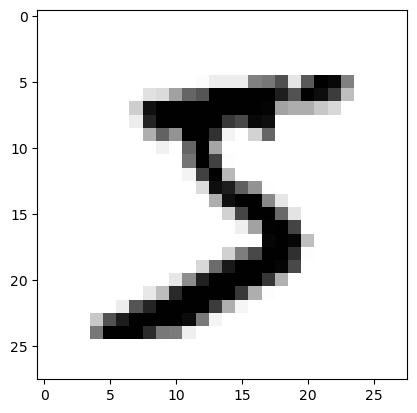

In [13]:
plt.imshow(image.reshape((28,28)),cmap='gist_yarg') 
#plt.imshow plots the image of the matrix representation

In [14]:
torch.manual_seed(101)
train_loader = DataLoader(train_data,batch_size=100,shuffle=True)
test_loader = DataLoader(test_data,batch_size=1000,shuffle=False)
#we shuffle the train data to make sure the data goes randomly in training
#also the test_data is just needed for the evaluation so we can use more batch_size

In [15]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

In [16]:
#FIRST BATCH
for images,labels in train_loader:
    break

In [17]:
images.shape #batch_size,color scale,2d matrix representation

torch.Size([100, 1, 28, 28])

Labels:  [   7    2    3    5    8    5    3    6    9    9    1    3]


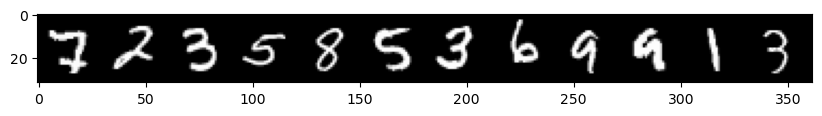

In [18]:
print('Labels: ',labels[:12].numpy())
im = make_grid(images[:12],nrow=12) 
# make_grid helps for plotting more than one image
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)));
#transposing for the imshow as it expects WHC whereas we has CWH

In [37]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120,84]):
        #28*28 =784 so we need to flatten the 2d representation of image into 1d 784 element tensor
        #this is used in input layer
        #classification from 0-9 so 10 output classes
        super().__init__()
        self.fc1 = nn.Linear(in_sz,layers[0])
        self.fc2 = nn.Linear(layers[0],layers[1])
        self.fc3 = nn.Linear(layers[1],out_sz)
    
    def forward(self,X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
        #we return the class with the probabilities,we can use it for finding the most probable class

In [38]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [47]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters()]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    #784*120
    #120*84
    #84*10

In [48]:
count_parameters(model)

 94080
   120
 10080
    84
   840
    10
______
105214


In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break
    

Batch shape: torch.Size([100, 1, 28, 28])


In [41]:
images.view(100,-1).size()

torch.Size([100, 784])

In [26]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1#b is the batch number and the other arguement is the training data
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        #returning the index of the highest probable class
        batch_corr = (predicted == y_train).sum()
        #correct predictions in this batch
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(1000,-1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.29955003  accuracy:  82.655%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.27258989  accuracy:  87.248%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.18161908  accuracy:  89.317%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.17174140  accuracy:  94.625%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.04962080  accuracy:  95.013%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.14178234  accuracy:  95.253%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.16812684  accuracy:  96.575%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.16944189  accuracy:  96.555%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.11215676  accuracy:  96.625%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.14404073  accuracy:  97.440%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.01286882  accuracy:  97.485%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.07540143  accuracy:  97.385%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.05159761  accuracy:  98.050%
epoch:  4  b

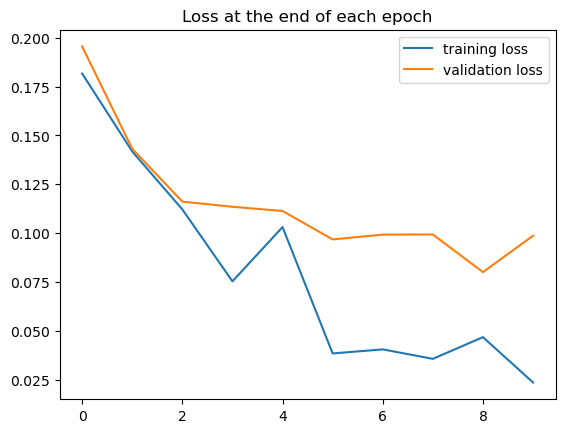

In [27]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();


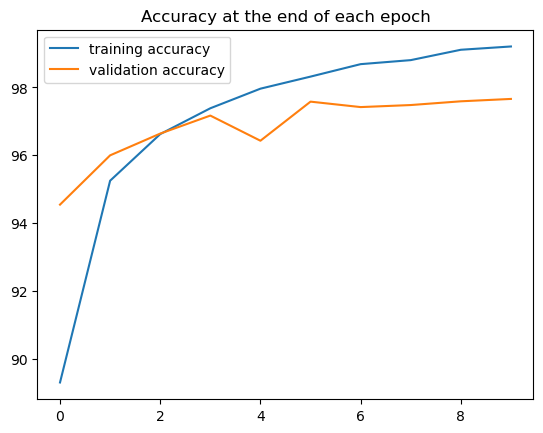

In [46]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [29]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') 
# print the most recent result as a percent

[tensor(9455), tensor(9600), tensor(9664), tensor(9717), tensor(9643), tensor(9758), tensor(9742), tensor(9748), tensor(9759), tensor(9766)]

Test accuracy: 97.660%


In [30]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [31]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9766/10000 =  97.660%


In [32]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 970    0    1    1    0    2    2    1    3    6]
 [   0 1121    1    0    0    0    4    8    1    2]
 [   3    4 1019   14    7    0    2   14    5    0]
 [   0    2    2  983    0   14    1    2    2    7]
 [   0    0    1    0  950    1    1    0    0    7]
 [   0    0    0    2    0  856    1    0    3    3]
 [   3    2    2    1    9    9  946    0    3    1]
 [   0    0    3    2    3    0    0  995    2    3]
 [   3    6    2    5    2    9    1    4  953    7]
 [   1    0    1    2   11    1    0    4    2  973]]


In [33]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

234

In [34]:
misses[:10]

array([   8,  115,  149,  151,  241,  247,  274,  321,  340,  381],
      dtype=int64)

In [35]:
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [   8  115  149  151  241  247  274  321  340  381  445  447]
Label: [   5    4    2    9    9    4    9    2    5    3    6    4]
Guess: [   6    9    9    8    8    2    3    7    3    7    0    9]


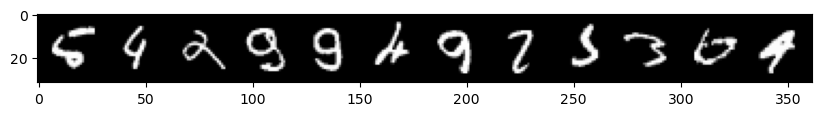

In [36]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));